In [1]:
#Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#CONSTs
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32

In [4]:
# Importing datas
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
train_normal = len(os.listdir(os.path.join(train_dir, "NORMAL")))
train_pneumonia = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))

test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/"
test_normal = len(os.listdir(os.path.join(test_dir, "NORMAL")))
test_pneumonia = len(os.listdir(os.path.join(test_dir, "PNEUMONIA")))

val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
val_normal = len(os.listdir(os.path.join(val_dir, "NORMAL")))
val_pneumonia = len(os.listdir(os.path.join(val_dir, "PNEUMONIA")))

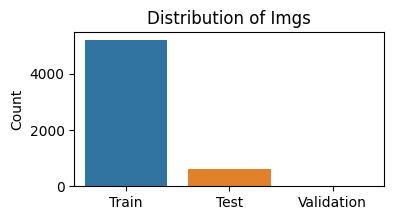

In [9]:
# Simple EDA
plt.figure(figsize=(4, 2))
sns.barplot(x=["Train", "Test", "Validation"], y=[train_normal + train_pneumonia, test_normal + test_pneumonia, val_normal + val_pneumonia])
plt.title("Distribution of Imgs")
plt.ylabel("Count")
plt.show()

In [6]:
# Data Augmentation

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# Model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

Epoch 1/5
163/163 [==============================] - 103s 581ms/step - loss: 0.5482 - accuracy: 0.7477
Epoch 2/5
163/163 [==============================] - 66s 404ms/step - loss: 0.4201 - accuracy: 0.7954
Epoch 3/5
163/163 [==============================] - 66s 407ms/step - loss: 0.3717 - accuracy: 0.8296
Epoch 4/5
163/163 [==============================] - 65s 401ms/step - loss: 0.3174 - accuracy: 0.8587
Epoch 5/5
163/163 [==============================] - 66s 406ms/step - loss: 0.3132 - accuracy: 0.8616


19/19 [==============================] - 4s 234ms/step - loss: 0.3427 - accuracy: 0.8684
Test Loss: 0.3427377939224243
Test Accuracy: 0.8684210777282715
20/20 [==============================] - 5s 240ms/step
              precision    recall  f1-score   support

      Normal       0.39      0.33      0.36       234
   Pneumonia       0.63      0.70      0.66       390

    accuracy                           0.56       624
   macro avg       0.51      0.51      0.51       624
weighted avg       0.54      0.56      0.55       624



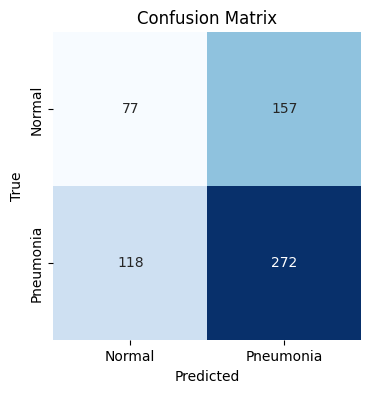

In [11]:
# Results
test_results = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)

print(classification_report(test_generator.classes, y_pred, target_names=["Normal", "Pneumonia"]))
confusion_mtx = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(4,4))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [12]:
model.save("pneumonia_model.h5")

In [13]:
import tensorflow as tf
from keras.models import load_model

# Load the saved model
loaded_model = tf.keras.models.load_model('pneumonia_model.h5')

In [15]:
class_names = train_generator.class_indices
print(class_names)

li = list(class_names.keys())
print(li)

{'NORMAL': 0, 'PNEUMONIA': 1}
['NORMAL', 'PNEUMONIA']


In [33]:
import cv2
image = cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg")
image_resize = cv2.resize(image,(150,150))
image = np.expand_dims(image_resize,axis=0)
print(image.shape)

pred = loaded_model.predict(image)
print(pred)

(1, 150, 150, 3)
1/1 [==============================] - 0s 18ms/step
[[0.]]


In [34]:
import cv2
image = cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg")
image_resize = cv2.resize(image,(150,150))
image = np.expand_dims(image_resize,axis=0)
print(image.shape)

pred = loaded_model.predict(image)
print(pred)

(1, 150, 150, 3)
1/1 [==============================] - 0s 18ms/step
[[0.]]
